In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pylab as plt
import torch
import scipy.stats.distributions as dist
import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [3]:
SIGMA = 0.1

class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(3.00, 0.001)])
        self.bounds = bounds
        self.Npix = Npix
#        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler2((Npix, Npix))
        self.sigma = torch.ones(Npix, Npix)*SIGMA
        self.sigma[:,:Npix//2] *= 1

    def get_pk_fn(self, theta):
        return lambda k: 1e-2*(k+0.05)**-theta[0]
        
    def sample_delta(self, pk_fn, use_bounds = True):
        if self.bounds is not None and use_bounds:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)

    def psf(self, rho):
#        return rho
        k = 5
        kernel = torch.ones(1, 1, 1+2*k, 1+2*k)/(1+2*k)**2
        return torch.nn.functional.conv2d(rho.unsqueeze(0).unsqueeze(0), kernel, padding = k).squeeze(0).squeeze(0)
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        omega = 2
#        rho = graph.node('rho', lambda delta: self.psf(np.exp(delta*omega)-1)/omega, delta)
        rho = graph.node('rho', lambda delta: (np.exp(self.psf(delta)*omega)-1)/omega, delta)
#        rho = graph.node('rho', lambda delta: self.psf(delta), delta)
        x = graph.node("x", lambda rho: rho + torch.randn(self.Npix, self.Npix)*self.sigma, rho)

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


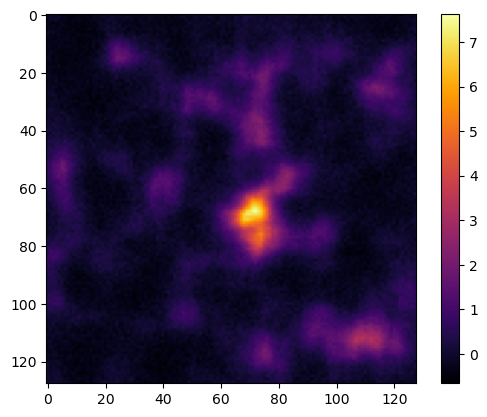

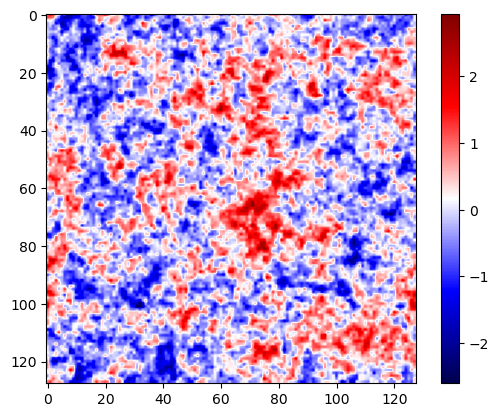

0.04662575


0.73159564

In [4]:
NPIX = 128
#bounds = torch.stack(s).cpu().float()
bounds = None
sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
sample0 = sim.sample(conditions = dict(theta = np.array([3.0])))
del sample0['pk_fn']
plt.imshow(sample0['x'], cmap = 'inferno')
plt.colorbar()
plt.show()
plt.imshow(sample0['delta'],cmap = 'seismic')
plt.colorbar()
plt.show()
print(sample0['delta'].mean())
sample0['delta'].std()

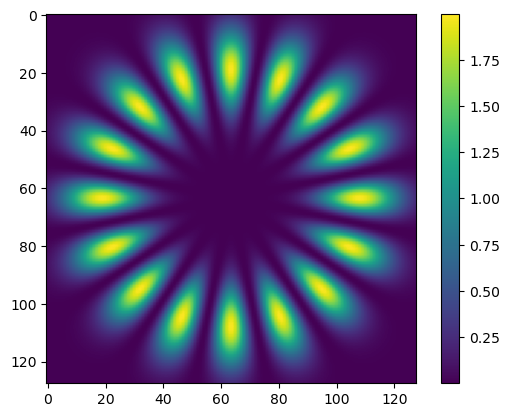

In [5]:
def gen_target_image(Npix):
    l = torch.linspace(-1, 1, Npix)
    L1, L2 = torch.meshgrid(l, l)
    R = (L1**2+L2**2)**0.5
    t = torch.exp(-(R-0.7)**2/2/0.15**2)
    t *= torch.cos(torch.arctan2(L1, L2)*16)+1
    return t

mu0 = gen_target_image(Npix = NPIX)
#torch.save(mu0, 'step2_target_image.pt')
#mu0 = torch.load("step2_target_image.pt")
plt.imshow(mu0)
plt.colorbar()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

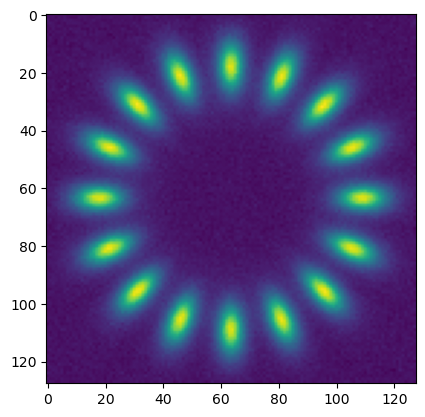

In [6]:
target = sim.sample(1, conditions={'delta': mu0})['x'][0]
target_wo_noise = sim.sample(1, conditions={'delta': mu0})['rho'][0]
plt.imshow(target)

In [7]:
def hook(sample):
    sample['x'] = sample['rho'] + np.random.randn(*sample['delta'].shape)* sim.sigma.numpy()
    return sample

In [8]:
samples = sim.sample(64*128, exclude = ['pk_fn'])
pk0 = sim.sample()['pk_fn']

  0%|          | 0/8192 [00:00<?, ?it/s]

## Inference networks

### Symmetric matrix

In [9]:
class GDGFactorMatrix:
    """Parametrization of a symmetric positive definite matrix.
    
    Q = G_T * D * G
    
    Input and output shapes are (B, NX, NY), where shape = (NX, NY).
    """
    def __init__(self):
        pass        
    
    def Q(self, x):
        """(B, NX, NY) --> (B, NX, NY)"""
        x = self._G(x)
        x = self._D*x
        x = self._G_T(x)
        return x
    
    def get_factors(self):
        GT = self._G_T
        G = self._G
        D = self._D
        return GT, D, G

    def _G(self, x):
        raise NotImplementedError
    
    @property
    def _D(self):
        raise NotImplementedError
    
    def _G_T(self, x):
        raise NotImplementedError

In [10]:
class PrecisionMatrixSingleConv(torch.nn.Module, GDGFactorMatrix):
    """Parametrization of a symmetric positive definite matrix.
    
    Q = G_T * D * G
    
    Input and output shapes are (B, NX, NY), where shape = (NX, NY).
    """
    def __init__(self, shape, k = 3):
        super().__init__()
        assert len(shape) == 2
        self._shape = shape
        
        self._conv1 = torch.nn.Conv2d(1, 1, 2*k+1, padding = k, bias = False)
        self._conv1.weight = torch.nn.Parameter(torch.ones_like(self._conv1.weight))
        self._conv1T = torch.nn.ConvTranspose2d(1, 1, 2*k+1, padding = k, bias = False)
        self._logD = torch.nn.Parameter(0*torch.ones(shape[0]*shape[1]))

    def forward(self, x):
        return self.Q(x)
    
    def _G(self, x):
        x = self._conv1(x.unsqueeze(1)).squeeze(1)
        x = x.flatten(1, 2)
        return x
    
    @property
    def _D(self):
        return torch.exp(self._logD)
    
    def _G_T(self, x):
        self._conv1T.weight = self._conv1.weight
        x = x.unflatten(1, self._shape)
        x = self._conv1T(x.unsqueeze(1)).squeeze(1)
        return x

In [11]:
class PrecisionMatrixFromFactors(torch.nn.Module, GDGFactorMatrix):
    """Parametrization of a symmetric positive definite matrix.
    
    Q = G_T * D * G
    
    Input and output shapes are (B, NX, NY), where shape = (NX, NY).
    """
    def __init__(self, G_T, D, G):
        super().__init__()
        self.__G = G
        self.__G_T = G_T
        self.__D = torch.nn.Parameter(D, requires_grad = False)

    def forward(self, x):
        return self.Q(x)
    
    def _G(self, x):
        return self.__G(x)
    
    @property
    def _D(self):
        return self.__D
    
    def _G_T(self, x):
        return self.__G_T(x)

In [12]:
# Test symmetry
x1 = torch.randn(1, NPIX, NPIX)
x2 = torch.randn(1, NPIX, NPIX)
SM = PrecisionMatrixSingleConv((NPIX, NPIX,))
print((x1*SM(x2)).sum(), (x2*SM(x1)).sum())
U2T, invD2, U2 = sim.powersampler.covariance_decomposition(pk0)
D2 = 1/invD2
SM = PrecisionMatrixFromFactors(U2T, D2, U2)
print((x1*SM(x2)).sum(), (x2*SM(x1)).sum())

tensor(17342.9492, grad_fn=<SumBackward0>) tensor(17342.9570, grad_fn=<SumBackward0>)
tensor(2547.1121) tensor(2547.1123)


### Sliced Score Matching Objective

In [13]:
class SlicedScoreMatching(torch.nn.Module):
    def __init__(self, Q_like, Q_prior, Q_trunc = None, b_trunc = None):
        super().__init__()
        self.Q_like = Q_like
        self.Q_prior = Q_prior
        self.Q_trunc = Q_trunc if Q_trunc is not None else lambda x: x*0
        self.b_trunc = b_trunc if b_trunc is not None else 0

    def __call__(self, b, z):
#        N = torch.randn_like(z)*z.std()
        idx1 = torch.randperm(len(z))
        idx2 = torch.randperm(len(z))
        N = z[idx1].detach() - z[idx2].detach()
#        loss = 0.5*((self.Q_like(z)+self.Q_prior(z)-b)*N)**2 - (self.Q_like(N)+self.Q_prior(N))*N
#        loss = 0.5*((self.Q_like(z-b)+self.Q_prior(z))*N)**2 - (self.Q_like(N)+self.Q_prior(N))*N        
#        loss = 0.5*((self.Q_like(z-b)+self.Q_prior(z)+self.Q_trunc(z-self.b_trunc))*N)**2 - (self.Q_like(N)+self.Q_trunc(N)+self.Q_prior(N))*N        
#        loss = 0.5*((self.Q_like(z)-b+self.Q_prior(z)+self.Q_trunc(z)-self.b_trunc)*N)**2 - (self.Q_like(N)+self.Q_trunc(N)+self.Q_prior(N))*N        
        loss = 0.5*((self.Q_like(z-b)+self.Q_prior(z-b-self.b_trunc)+self.Q_trunc(z-self.b_trunc))*N)**2 - (self.Q_like(N)+self.Q_trunc(N)+self.Q_prior(N))*N        
#        N = torch.randn_like(z)
#        loss = 0.5*((self.Q_like(z)+self.Q_prior(z)-b))**2 - (self.Q_like(N)+self.Q_prior(N))*N
        loss = loss.reshape(-1)
        return swyft.AuxLoss(loss, 'x')
    
    def sample(self, b, N = 1, omega = 1e-2, steps = 1000, reset = True, gamma = 1):
        U2T, D2, U2 = self.Q_prior.get_factors()
        _G1T, _D1, _G1 = self.Q_like.get_factors()
        G1T = lambda x: _G1T(x.unsqueeze(0)).detach().squeeze(0)
        G1 = lambda x: _G1(x.unsqueeze(0)).detach().squeeze(0)
        D1 = _D1.detach()*gamma
        b = b.detach()*gamma
        sampler = swyft.utils.GEDASampler2(omega, G1, D1, G1T, U2, D2, U2T, out_shape = (NPIX, NPIX), b = b)
        s = sampler.sample(N, steps=steps, initialize_with_Q2=True, reset = reset)
        return s

### Inference network

In [14]:
class Network(swyft.AdamWReduceLROnPlateau, swyft.SwyftModule):
    def __init__(self, Q_trunc = None, b_trunc = None):
        super().__init__()
        self.learning_rate = 1e-3
        self.early_stopping_patience = 10000
        
        UT, D, U = sim.powersampler.covariance_decomposition(pk0)
        self.Q_prior = PrecisionMatrixFromFactors(UT, 1/D, U)
        self.Q_trunc = Q_trunc
        self.b_trunc = b_trunc
        self.Q_like = PrecisionMatrixSingleConv((NPIX, NPIX))
        self.SSM = SlicedScoreMatching(Q_like = self.Q_like, Q_prior = self.Q_prior, Q_trunc = self.Q_trunc, b_trunc = self.b_trunc)
        self.norm = swyft.networks.OnlineStandardizingLayer((NPIX, NPIX))
        
        self.map1 = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),
            torch.nn.Conv2d(1, 16, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 16, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 1, 5, padding=2),
            torch.nn.Flatten(0, 1)
        )
        self.map2 = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),
            torch.nn.Conv2d(1, 16, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 1, 3, padding=1),
            torch.nn.Flatten(0, 1)
        )
        
    def estimator(self, x):
#        x = self.norm(x)
        x = self.map1(x)# + x
#        x = self.map2(x)# + x
        return x

    def forward(self, A, B):
        x = A['x']
        b = self.estimator(x)
        z = B['delta'][:len(x)]
        return self.SSM(b, z)

In [15]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64, max_epochs = 20)
dm = swyft.SwyftDataModule(samples, batch_size=64, on_after_load_sample=hook, shuffle=True)
network = Network()

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/weniger/.conda/envs/lensing/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(network, dm)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | Q_prior | PrecisionMatrixFromFactors | 16.4 K
1 | Q_like  | PrecisionMatrixSingleConv  | 16.4 K
2 | SSM     | SlicedScoreMatching        | 32.8 K
3 | norm    | OnlineStandardizingLayer   | 0     
4 | map1    | Sequential                 | 7.2 K 
5 | map2    | Sequential                 | 2.6 K 
--------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 31it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Reloading best model: /gpfs/home2/weniger/swyft/notebooks/dev/lightning_logs/version_4635844/checkpoints/epoch=19-step=2091.ckpt


In [24]:
network.cuda()
N = torch.randn(10_000, NPIX, NPIX).double().cuda()
mean_diag = (network.SSM.Q_like(N)*N).mean().item()
print("Mean std error:", 1/mean_diag**0.5)
# print("Mean std error:", 1/mean_diag)
# 1/(network.SSM.Q_like(N)*N).sum(axis=1).sum(axis=1)**0.5

Mean std error: 0.3110867681230553


In [25]:
network.cuda()
#mu0n = mu0+torch.randn_like(mu0)*SIGMA
mu0n = torch.tensor(target)
b = network.estimator(mu0n.cuda().double().unsqueeze(0)).squeeze(0).detach()

b = b.cuda()
b = network.SSM.Q_like(b.unsqueeze(0)).detach().squeeze(0) + network.SSM.Q_prior(b.unsqueeze(0)).detach().squeeze(0)
#network.cuda()
s = network.SSM.sample(b, N = 10, omega = 1e-3, steps = 100, gamma = 1)

  0%|          | 0/10 [00:00<?, ?it/s]

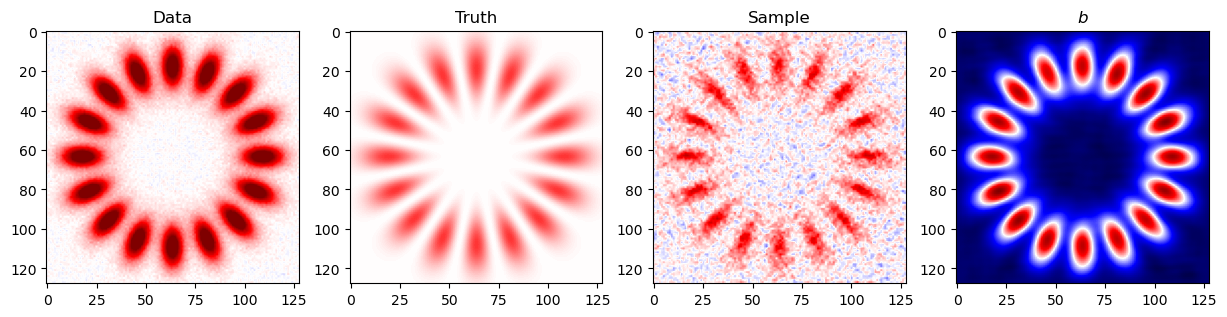

In [26]:
plt.figure(figsize = (15, 5))
plt.subplot(141)
plt.title("Data")
plt.imshow(mu0n.cpu(), vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(142)
plt.title("Truth")
plt.imshow(mu0, vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(143)
plt.title("Sample")
plt.imshow(s[0].cpu(), vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(144)
plt.title("$b$")
plt.imshow(b.cpu(), cmap = 'seismic')#, vmin = -5, vmax = 5)
#plt.colorbar()
#s[0].std()/d.std()

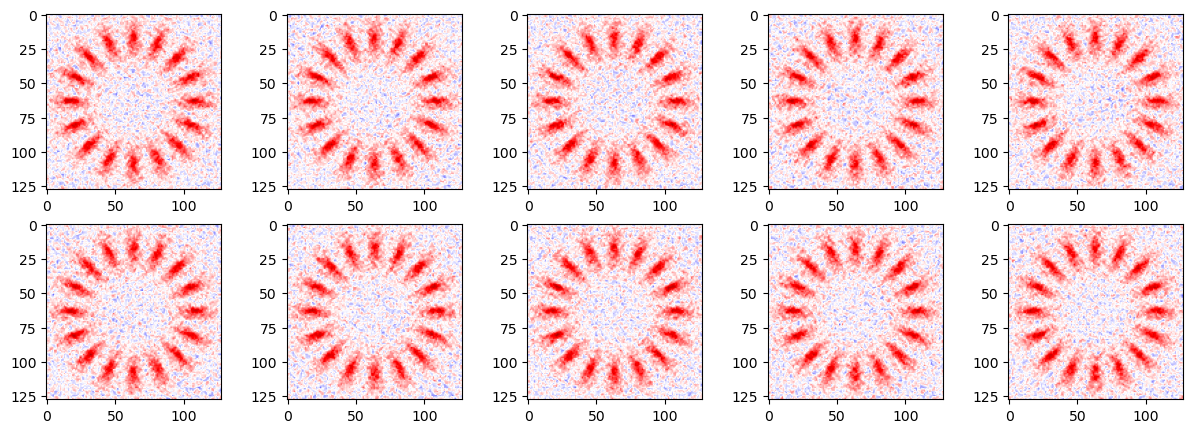

In [27]:
plt.figure(figsize = (15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(s[i-1].cpu(), vmin = -5, vmax = 5, cmap = 'seismic')

Image std: 0.4237168046582447


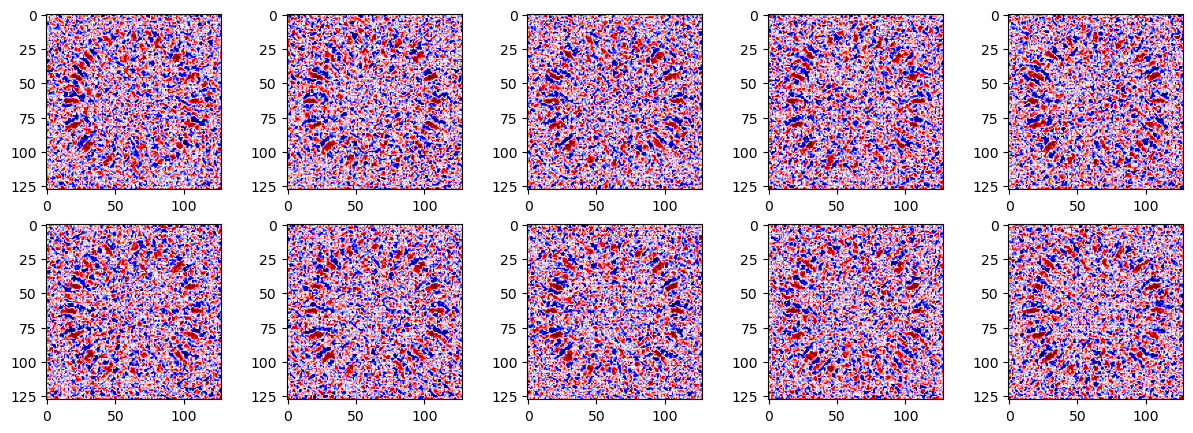

In [28]:
plt.figure(figsize = (15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(s[i-1].cpu()-mu0.cpu(), vmin = -1, vmax = 1, cmap = 'seismic')
print("Image std:", (torch.stack(s).cpu()-mu0.cpu()).std().item())

In [ ]:
s2 = network.SSM.sample(b, N = 2048, omega = 2e-3, steps = 100, gamma = .1)

  0%|          | 0/2048 [00:00<?, ?it/s]

In [ ]:
bounds = torch.stack(s2).cpu().float()
sim2 = SimulatorBlob(Npix = NPIX, bounds = bounds)
samples2 = sim2.sample(64*128, exclude = ['pk_fn'])
pk0 = sim.sample()['pk_fn']

In [ ]:
plt.figure(figsize = (15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples2[i]['x'] - target, vmin = -1, vmax = 1, cmap = 'seismic')
#print("Image std:", (torch.stack(s3).cpu()-mu0.cpu()).std().item())

In [ ]:
plt.imshow(samples2['x'].mean(axis=0) - target, vmin = -1, vmax = 1, cmap = 'seismic')
(samples2['x'].mean(axis=0) - target).std()

In [ ]:
plt.imshow(samples2[0]['x'], cmap = 'inferno')
plt.colorbar()
plt.show()

In [ ]:
trainer2 = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64, max_epochs = 20)
dm2 = swyft.SwyftDataModule(samples2, batch_size=64, on_after_load_sample=hook, shuffle=True)
network.cuda()
Q_trunc = lambda x: network.SSM.Q_like(x).detach()*0.1
b_trunc = network.estimator(mu0n.cuda().double().unsqueeze(0)).squeeze(0).detach()
network2 = Network(Q_trunc=Q_trunc, b_trunc = b_trunc)

In [ ]:
trainer2.fit(network2, dm2)

In [ ]:
network2.cuda()
N = torch.randn(10_000, NPIX, NPIX).double().cuda()
mean_diag = (network2.SSM.Q_like(N)*N).mean().item()
print("Mean std error:", 1/mean_diag**0.5)
# print("Mean std error:", 1/mean_diag)
# 1/(network.SSM.Q_like(N)*N).sum(axis=1).sum(axis=1)**0.5

In [ ]:
network2.cuda()
#mu0n = mu0+torch.randn_like(mu0)*SIGMA
b2 = network2.estimator(mu0n.cuda().double().unsqueeze(0)).squeeze(0).detach()

b2 = b2.cuda()
b2 = network2.SSM.Q_like(b2.unsqueeze(0)).detach().squeeze(0) + network2.SSM.Q_prior(b2.unsqueeze(0)).detach().squeeze(0)
#network.cuda()
s3 = network2.SSM.sample(b2, N = 300, omega = 3e-4, steps = 500, gamma = 1)

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(141)
plt.title("Data")
plt.imshow(mu0n.cpu(), vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(142)
plt.title("Truth")
plt.imshow(mu0, vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(143)
plt.title("Sample")
plt.imshow(s3[0].cpu(), vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(144)
plt.title("$b$")
plt.imshow(b2.cpu(), cmap = 'seismic')#, vmin = -5, vmax = 5)
#plt.colorbar()
#s[0].std()/d.std()

In [ ]:
plt.figure(figsize = (15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(s3[i-1].cpu(), vmin = -5, vmax = 5, cmap = 'seismic')

In [ ]:
plt.figure(figsize = (15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(s3[i-1].cpu()-mu0.cpu(), vmin = -1, vmax = 1, cmap = 'seismic')
print("Image std:", (torch.stack(s3).cpu()-mu0.cpu()).std().item())

In [ ]:
bounds2 = torch.stack(s3).cpu().float()
sim3 = SimulatorBlob(Npix = NPIX, bounds = bounds2)
samples3 = sim3.sample(100, exclude = ['pk_fn'])

In [ ]:
plt.figure(figsize = (15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples3[i]['x'] - target, vmin = -1, vmax = 1, cmap = 'seismic')
#print("Image std:", (torch.stack(s3).cpu()-mu0.cpu()).std().item())

In [ ]:
res3 = samples3['rho'].mean(axis=0) - target_wo_noise
max3 = samples3['rho'].max(axis=0) - target_wo_noise
min3 = samples3['rho'].min(axis=0) - target_wo_noise
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(res3, vmin = -1, vmax = 1, cmap = 'seismic')
plt.subplot(132)
plt.imshow(max3, vmin = -1, vmax = 1, cmap = 'seismic')
plt.subplot(133)
plt.imshow(min3, vmin = -1, vmax = 1, cmap = 'seismic')
res3.std()

In [ ]:
err3 = samples3['x'].std(axis=0)
plt.imshow(err3, vmin = 0, vmax = 0.3, cmap = 'inferno')
plt.colorbar()

In [ ]:
plt.imshow(abs(res3)/err3, vmin = 0, vmax = 3, cmap = 'inferno')
plt.colorbar()

In [ ]:
plt.hist(abs(res3).flatten()/err3.flatten());

In [ ]:
plt.subplot(121)
plt.imshow(bounds2.max(axis=0).values - mu0, vmin = -1, vmax = 1, cmap = 'seismic')
plt.colorbar()
plt.subplot(122)
plt.imshow(bounds2.min(axis=0).values - mu0, vmin = -1, vmax = 1, cmap = 'seismic')
plt.colorbar()

In [ ]:
from scipy.ndimage import gaussian_filter
s3s = [gaussian_filter(s3[i].cpu().numpy(), 3) for i in range(len(s3))]
std = np.array(s3s).std(axis=0)#+s3s[0]*0.001
plt.imshow(std, vmin = 0.004, vmax = 0.005)
plt.colorbar()